In [1]:
from funcs.auroralring import AuroralRing
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import emcee
import corner

def get_full_rotation_line(ring, n=100, alpha=np.linspace(0, 2*np.pi, 100).reshape(100,1)):

    full_flux_analytical = ring.get_flux_analytically(alpha)

    mf = np.max(full_flux_analytical)
    
    if mf != 0:
        full_flux_analytical /= mf

    return full_flux_analytical

# dark mode
plt.style.use('dark_background')

from multiprocessing import Pool

In [18]:
# set up the ring
logf_true = np.log(0.5)
i_rot_true = 60/180*np.pi
i_mag_true = 45 * np.pi/180
sin_i_mag_true = np.sin(i_mag_true)
sin_i_rot_true = np.sin(i_rot_true)
latitude_true = 89*np.pi/180
sin_latitude_true = np.sin(latitude_true)
n=100
P_rot= 1.5 * np.pi
omega = 2*np.pi/P_rot
Rstar = 1
vmax = omega * Rstar * 695700. / 86400.
v_bins = np.linspace(-vmax*1.05, vmax*1.05, 100)
v_mids = (v_bins[1:] + v_bins[:-1])/2
phi = np.linspace(0, 2*np.pi, 1800)
convert_to_kms = omega / 86400 * Rstar * 695700.

ring = AuroralRing(i_rot=i_rot_true, i_mag=i_mag_true, latitude=latitude_true,
                   width=1 * np.pi/180, Rstar=1, P_rot=1.5 * np.pi, N=60, 
                   norm=11, gridsize=int(4e5), v_bins=v_bins, v_mids=v_mids,
                   phi=phi, omega=omega, convert_to_kms=convert_to_kms)



Text(0, 0.5, 'normalized flux')

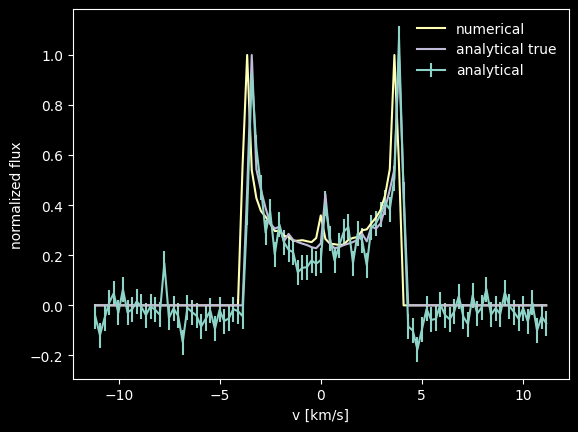

In [19]:
ffa_ = get_full_rotation_line(ring, n=n)

# calculate the flux 
# this serves as measurement
full_flux_numerical = np.zeros_like(ring.v_mids)

for alpha in np.linspace(0, 2*np.pi, n):
    full_flux_numerical += ring.get_flux_numerically(alpha)

flux_err = np.ones_like(full_flux_numerical) * 0.05
ffa =  ffa_ - 0.025 + np.random.randn(len(ffa_)) * 0.05
full_flux_numerical /= np.max(full_flux_numerical)

plt.errorbar(ring.v_mids, ffa, yerr = flux_err, label='analytical')
plt.plot(ring.v_mids, full_flux_numerical, label='numerical')
plt.plot(ring.v_mids, ffa_, label='analytical true')
plt.legend(frameon=False)
plt.xlabel('v [km/s]')
plt.ylabel('normalized flux')

In [20]:
%timeit get_full_rotation_line(ring, n=n)

6.36 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


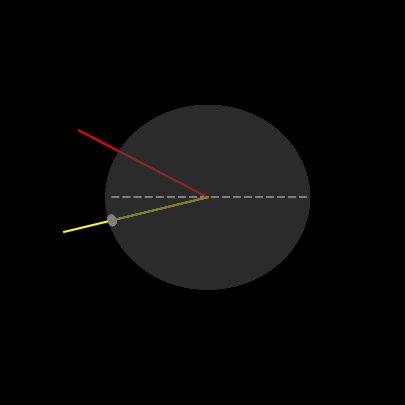

In [21]:
fig, ax = ring.plot_setup_sphere()

ring.plot_sphere_with_auroral_ring(ax, alpha=alpha)
ring.plot_layout_sphere(ax, view="observer left")


In [22]:
def log_likelihood(theta, ffa, flux_err, v_bins, v_mids, phi, omega):

    sin_i_rot, sin_i_mag, sin_latitude, log_f = theta
    ring = AuroralRing(i_rot=np.arcsin(sin_i_rot), i_mag=np.arcsin(sin_i_mag), latitude=np.arcsin(sin_latitude),
                   width=1 * np.pi/180, Rstar=1, P_rot=1.5 * np.pi, N=60, 
                   norm=11, gridsize=0, v_bins=v_bins, v_mids=v_mids,
                   phi=phi, omega=omega, convert_to_kms=convert_to_kms)
    model = get_full_rotation_line(ring, n=100)
    # plt.plot(ring.v_mids, model, c="w", alpha=0.05)
    
    sigma2 = flux_err**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((ffa - model) ** 2 / sigma2 + np.log(sigma2))

In [23]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([sin_i_rot_true, sin_i_mag_true, sin_latitude_true, logf_true]) + 0.01 * np.random.randn(4)
soln = minimize(nll, initial, args=(ffa, flux_err, v_bins, v_mids, phi, omega))
i, m, l, lf = soln.x

print("Maximum likelihood estimates:")
print("i_rot = {0:.3f}".format(np.arcsin(i)*180/np.pi))
print("logf = {0:.3f}".format(lf))
print("m = {0:.3f}".format(np.arcsin(m)*180/np.pi))
print("l = {0:.3f}".format(np.arcsin(l)*180/np.pi))


Maximum likelihood estimates:
i_rot = 60.591
logf = -0.684
m = 43.822
l = 79.679


In [24]:
def log_prior(theta):
    i, m, l, logf = theta
    if  0<i<1 and 0 < m < 1 and 0 < l < 1 and -10 < logf < 1:
        return 0.0
    return -np.inf


def log_probability(theta, y, yerr, v_bins, v_mids, phi, omega):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,  y, yerr, v_bins, v_mids, phi, omega)

In [25]:

# initialize the walkers
pos = soln.x + 1e-2 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

# parallelize the process
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(ffa, flux_err, v_bins, v_mids, phi, omega),
                                    pool=pool)
    # run MCMC
    sampler.run_mcmc(pos, 10000, progress=True)
    

  0%|          | 0/10000 [00:00<?, ?it/s]/home/ilin/Documents/2023_10_Oblique_Ring/.venv/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [17:35<00:00,  9.47it/s]


/tmp/ipykernel_824955/1849078704.py:7: RuntimeWarning: invalid value encountered in arcsin
  ax.plot(np.arcsin(samples[:, :, i])*180/np.pi, "w", alpha=0.3)


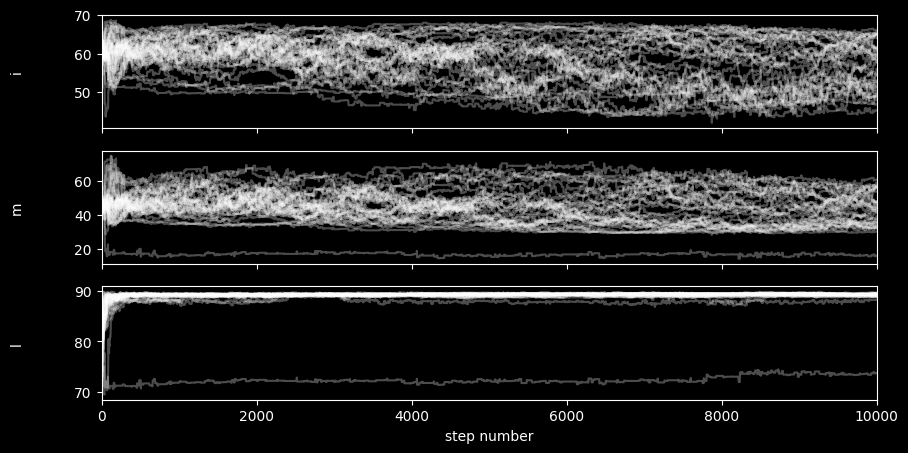

In [26]:
fig, axes = plt.subplots(3, figsize=(10, 5), sharex=True)
samples = sampler.get_chain()
labels = ["i", "m", "l"]

for i in range(ndim-1):
    ax = axes[i]
    ax.plot(np.arcsin(samples[:, :, i])*180/np.pi, "w", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

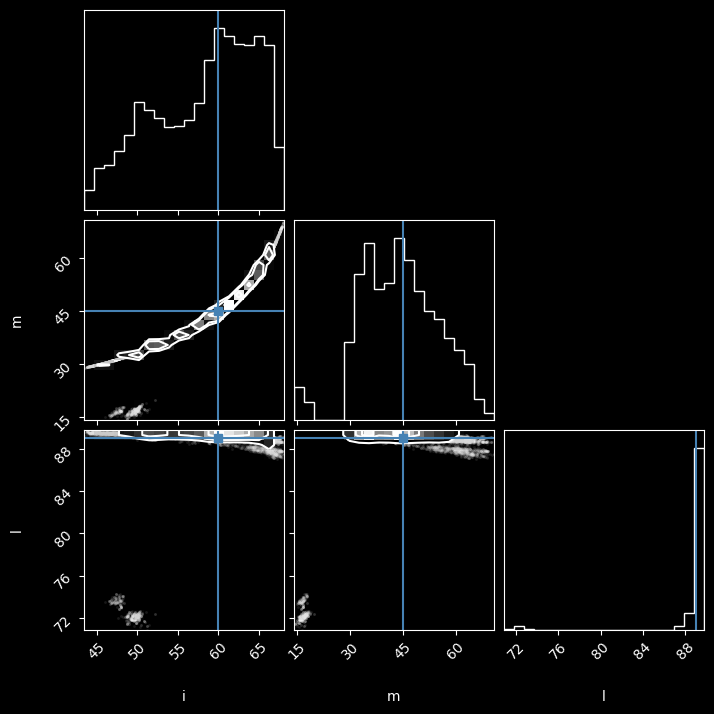

In [27]:
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)[:,:-1]

fs = np.arcsin(flat_samples)*180/np.pi
# fs = flat_samples   
fig = corner.corner(fs, labels=labels, truths=np.arcsin(np.array([sin_i_rot_true, sin_i_mag_true, sin_latitude_true]))* 180 /np.pi);

In [28]:
import multiprocessing as mp

num_workers = mp.cpu_count()

In [29]:
num_workers

12